# Some Preliminary Data Visualizations

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Getting the data
df = pd.read_csv("../../Data/csvs/full_data.csv")

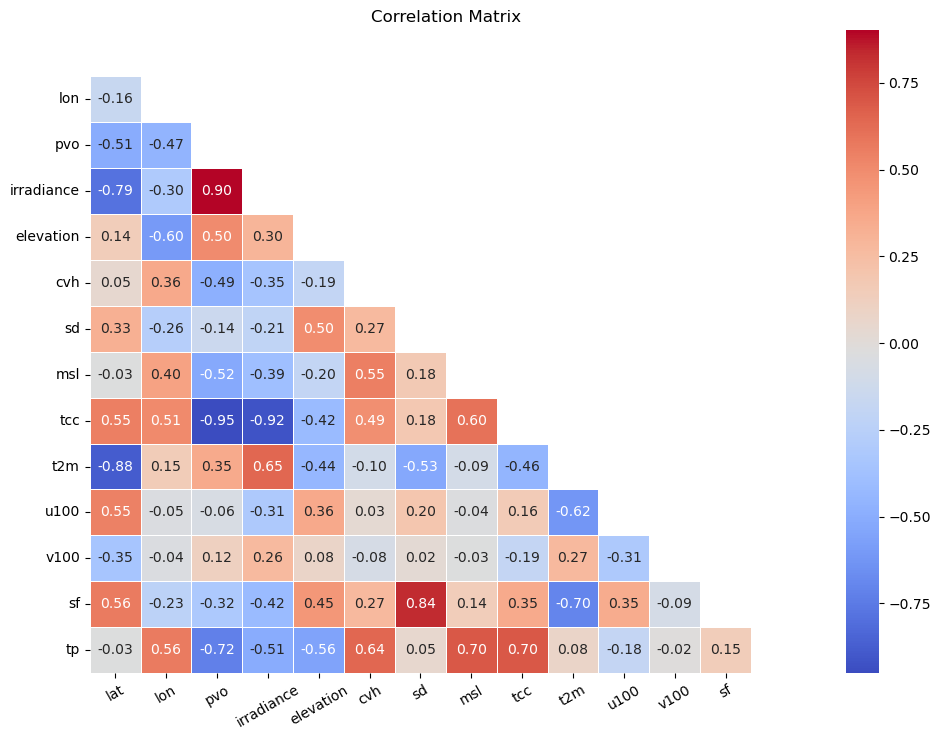

In [3]:
# Correlation matrix for all features
corr_mat = df.corr()

# Hiding upper right half
mask = np.triu(np.ones_like(corr_mat, dtype = bool))

# Plot using seaborn
fig, ax = plt.subplots(1, 1, figsize = (10, 7.5))
ax = sns.heatmap(corr_mat, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5, mask = mask)
ax.set_xticks([(i + 0.5) for i in range(13)])
ax.set_xticklabels(df.columns[: -1].to_list(), rotation = 30)
ax.set_yticks([(i + 1.5) for i in range(13)])
ax.set_yticklabels(df.columns[1:].to_list())
ax.set_title("Correlation Matrix")
plt.tight_layout()

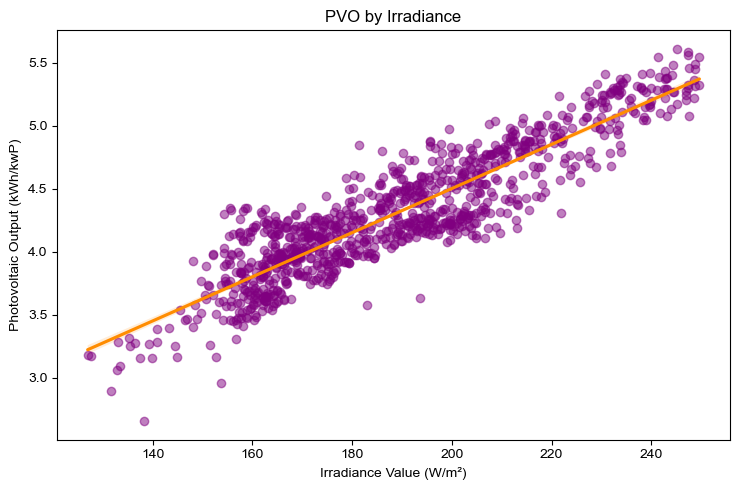

In [4]:
# Plotting PVO by irradiance - using a sample of the data
sample = df.sample(1000)
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.regplot(x = "irradiance", y = "pvo", data = sample, color = "darkorange", scatter = False)
ax.scatter(x = sample["irradiance"], y = sample["pvo"], color = "purple", alpha = 0.5)
ax.set_xlabel("Irradiance Value (W/m²)")
ax.set_ylabel("Photovoltaic Output (kWh/kwP)")
ax.set_title("PVO by Irradiance")
plt.tight_layout()

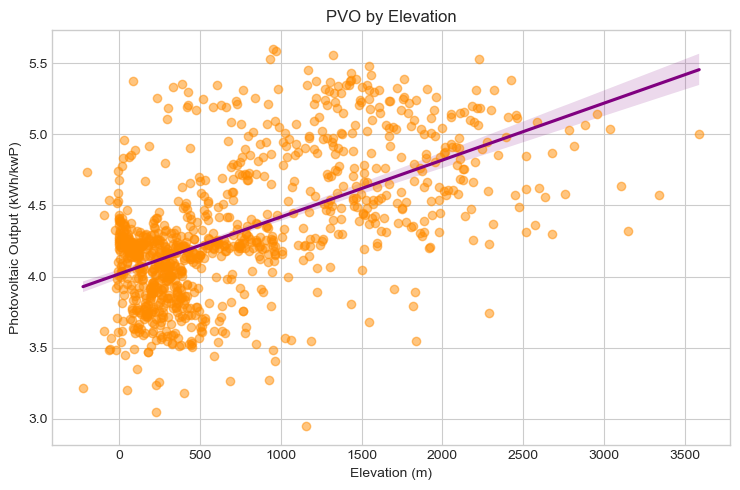

In [5]:
# Plotting PVO by irradiance - using a sample of the data
sample = df.sample(1000)
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
plt.style.use("seaborn-v0_8-whitegrid")
sns.regplot(x = "elevation", y = "pvo", data = sample, color = "purple", scatter = False)
ax.scatter(x = sample["elevation"], y = sample["pvo"], color = "darkorange", alpha = 0.5)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Photovoltaic Output (kWh/kwP)")
ax.set_title("PVO by Elevation")
plt.tight_layout()

In [10]:
import sys
import os
sys.path.append(os.path.abspath('../Models'))

from ../Models/models.py import LM
lm = LM()
lm.loadModel("../../Data/CSVS/LM.pt.tar")

SyntaxError: invalid syntax (8035692.py, line 1)

In [12]:
import pandas as pd
import numpy as np

data_for_grid = pd.read_csv("../../Data/CSVS/full_data.csv")

X = data_for_grid.drop(['pvo', 'irradiance'], axis=1)

lat_min, lat_max = data_for_grid['lat'].min(), data_for_grid['lat'].max()
lon_min, lon_max = data_for_grid['lon'].min(), data_for_grid['lon'].max()

means = X.mean()
stds = X.std()

# create grid
lat_grid = np.arange(lat_min, lat_max, 0.1)
lon_grid = np.arange(lon_min, lon_max, 0.1)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)
lat_flat = lat_mesh.flatten()
lon_flat = lon_mesh.flatten()

grid_df = pd.DataFrame({'lat': lat_flat, 'lon': lon_flat})

In [13]:
import plotly.graph_objects as go
import pandas as pd
import torch

data = pd.read_csv("../../Data/CSVS/full_data.csv")
data = data.sample(10000)

data['lat_orig'] = data['lat']
data['lon_orig'] = data['lon']

X = data.drop(['pvo', 'irradiance', 'lat_orig', 'lon_orig'], axis=1)

# Standardize features as done during training
for col in X.columns:
    if col in means and col in stds:
        X[col] = (X[col] - means[col]) / stds[col]

# make predictions
with torch.no_grad():
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    predictions = lm.predict(X_tensor).cpu().numpy().flatten()

data['predicted_pv'] = predictions

data['text'] = 'Actual PV: ' + data['pvo'].round(3).astype(str) + '<br>' + \
               'Predicted PV: ' + data['predicted_pv'].round(3).astype(str)

fig = go.Figure(data=go.Scattergeo(
    lon=data['lon_orig'],
    lat=data['lat_orig'],
    text=data['text'],
    mode='markers',
    marker=dict(
        size=5,
        color=data['predicted_pv'],
        colorscale='Viridis',
        colorbar_title="Predicted PV Output",
        showscale=True,
        opacity=0.4
    )
))

# only show USA
fig.update_layout(
    title='Predicted Photovoltaic Output',
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        countrycolor='rgb(255, 255, 255)',
        showlakes=True,
        lakecolor='rgb(166, 206, 227)',
        showsubunits=True,
        subunitcolor='rgb(50, 50, 50)',
        subunitwidth=1
    )
)

fig.show()